<>:232: SyntaxWarning: invalid escape sequence '\,'
<>:232: SyntaxWarning: invalid escape sequence '\,'
/var/folders/ys/y877k0vd3bj8jdjg6z66dk980000gn/T/ipykernel_4516/4165899625.py:232: SyntaxWarning: invalid escape sequence '\,'
  plt.annotate(r'$|q| = 0.7830$, '+'\n'+'$d_{ICC} = 12.74 \, \AA$', xy=(0.0520, 0.8), xycoords='axes fraction',


Processing folder: AA
Processing folder: AR
Processing folder: AAR
Processing folder: Inner
Processing folder: Outer
Processing folder: No_Charge
Processing folder: liquid_100kPa
Covariance Factor: 0.834428
Standard Deviation of Data: 0.599213
Bandwidth: 0.500000
Covariance Factor: 0.551049
Standard Deviation of Data: 0.907360
Bandwidth: 0.500000
Covariance Factor: 0.507093
Standard Deviation of Data: 0.986013
Bandwidth: 0.500000
Covariance Factor: 0.580438
Standard Deviation of Data: 0.861418
Bandwidth: 0.500000
Covariance Factor: 0.474506
Standard Deviation of Data: 1.053726
Bandwidth: 0.500000
Covariance Factor: 0.572013
Standard Deviation of Data: 0.874106
Bandwidth: 0.500000
Covariance Factor: 0.493260
Standard Deviation of Data: 1.013665
Bandwidth: 0.500000


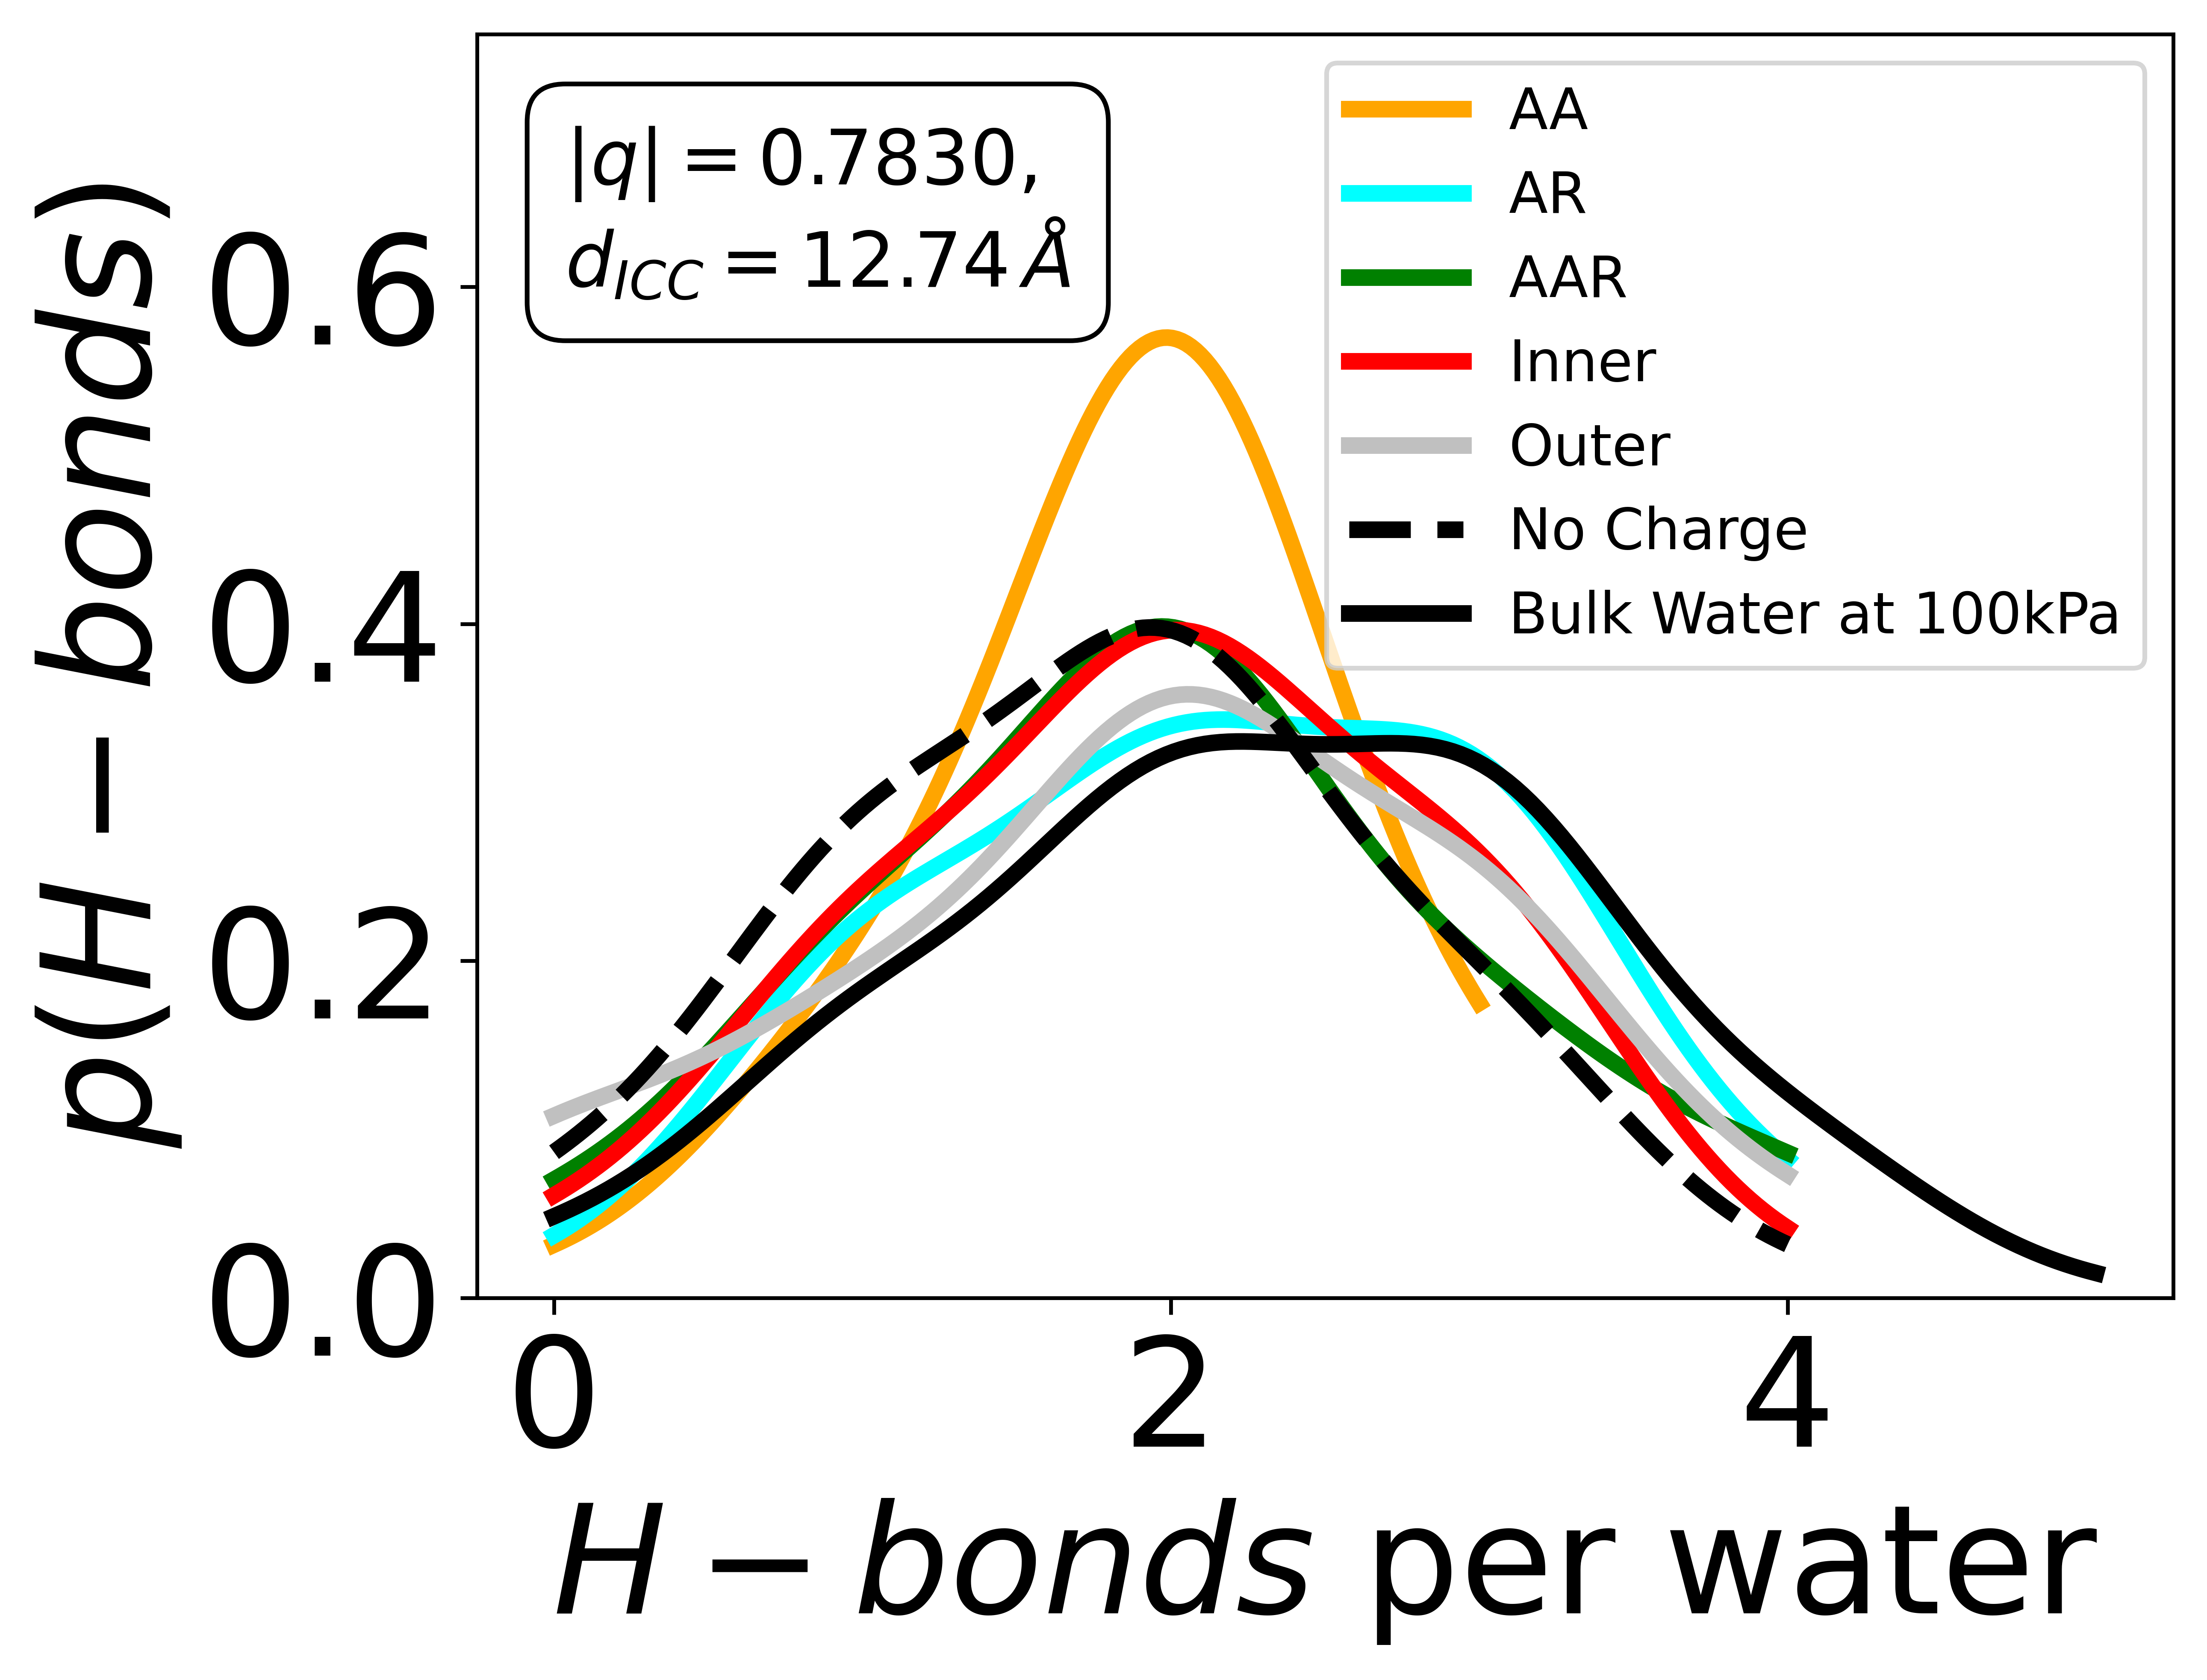

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Function to read the combined XYZ file and group atoms into water molecules
# Function to read the combined XYZ file and group atoms into water molecules
def read_xyz_and_group_molecules(filename):
    atoms = []
    with open(filename, 'r') as f:
        lines = f.readlines()
    num_atoms = int(lines[0])
    # Extract box dimensions from the comment line (assuming it's provided)
    box_line = lines[1].strip()
    box_lengths = None
    if 'box lengths:' in box_line:
        box_lengths = np.array([float(x) for x in box_line.split('box lengths:')[1].split()])
    else:
        # If box dimensions are not provided, set them manually
        box_lengths = np.array([30.8, 30.8, 30.8])  # Box dimensions in Ångströms

    # Skip the first two lines (atom count and comment)
    atom_id = 0
    for line in lines[2:]:
        parts = line.strip().split()
        if len(parts) >= 4:
            atom_type = parts[0]
            x, y, z = map(float, parts[1:4])
            atoms.append({'id': atom_id, 'type': atom_type, 'position': np.array([x, y, z])})
            atom_id += 1

    # Separate lists for oxygen and hydrogen atoms
    oxygen_atoms = []
    hydrogen_atoms = []
    for atom in atoms:
        if atom['type'] == 'O':
            oxygen_atoms.append(atom)
        elif atom['type'] == 'H':
            atom['used'] = False  # Initialize 'used' flag
            hydrogen_atoms.append(atom)

    # Assign hydrogens to oxygens based on proximity
    molecules = []
    for o_atom in oxygen_atoms:
        o_pos = o_atom['position']
        # Calculate distances to all unused hydrogen atoms considering PBCs
        distances = []
        for h_atom in hydrogen_atoms:
            if not h_atom['used']:
                h_pos = h_atom['position']
                vec = minimum_image_distance(h_pos - o_pos, box_lengths)
                dist = np.linalg.norm(vec)
                distances.append((dist, h_atom))
        # Sort hydrogens by distance
        distances.sort(key=lambda x: x[0])
        # Select the two closest hydrogens within a cutoff distance
        h_cutoff = 1.00  # Adjust this cutoff distance if necessary
        h_assigned = []
        for dist, h_atom in distances:
            if dist <= h_cutoff:
                h_assigned.append(h_atom)
                if len(h_assigned) == 2:
                    break
        if len(h_assigned) == 2:
            # Mark assigned hydrogens as used
            h_assigned[0]['used'] = True
            h_assigned[1]['used'] = True
            molecule = {
                'O': o_pos,
                'H': [h_assigned[0]['position'], h_assigned[1]['position']]
            }
            molecules.append(molecule)

    return molecules, box_lengths

# Function to apply minimum image convention
def minimum_image_distance(vec, box_lengths):
    return vec - box_lengths * np.round(vec / box_lengths)

# Function to calculate hydrogen bond lengths, angles, and bond counts per molecule
def hydrogen_bond_analysis(molecules, box_lengths):
    hb_lengths = []  # List to store hydrogen bond lengths
    hb_angles = []  # List to store hydrogen bond angles
    hb_counts = [] * len(molecules)  # List to store the number of hydrogen bonds per molecule, initialized to 0

    num_molecules = len(molecules)
    for i in range(num_molecules):
        O_i = molecules[i]['O']  # Oxygen atom of molecule i
        H_i_list = molecules[i]['H']  # Hydrogen atoms of molecule i
        hb_counter = 0
        
        for j in range(num_molecules):
            if i == j:
                continue
            H_j_list = molecules[j]['H']
            O_j = molecules[j]['O']  # Oxygen atom of molecule j
            # Compute O_i - O_j vector considering Periodic Boundary Conditions (PBCs)
            vec_Oi_Oj = minimum_image_distance(O_j - O_i, box_lengths)
            OO_distance = np.linalg.norm(vec_Oi_Oj)
            
            if OO_distance < 3.0:  # Only consider molecules with O-O distance < 3.5 Å
                # For each hydrogen H_i of molecule i
                for H_i in H_i_list:
                    # Compute vectors considering PBCs
                    vec_Oi_Hi = minimum_image_distance(H_i - O_i, box_lengths)
                    vec_Oj_Hi = minimum_image_distance(H_i - O_j, box_lengths)
                    
                    # Angle at H_i between O_i - H_i and O_j - H_i
                    cos_theta = np.dot(vec_Oi_Hi, vec_Oj_Hi) / (np.linalg.norm(vec_Oi_Hi) * np.linalg.norm(vec_Oj_Hi))
                    angle_rad = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid numerical issues
                    angle_deg = np.degrees(angle_rad)
                    
                    # Check if the angle is less than 30 degrees (criterion for hydrogen bond)
                    if angle_deg > 150.0:
                        # Calculate hydrogen bond length (H_i to O_j)
                        OH_distance = np.linalg.norm(vec_Oj_Hi)
                        
                        # Append the bond length and angle to the respective lists
                        hb_lengths.append(OH_distance)
                        hb_angles.append(angle_deg)
                        
                        # Increment the hydrogen bond count for molecule i
                        hb_counter += 1
                                # For each hydrogen H_i of molecule i
                for H_j in H_j_list:
                    # Compute vectors considering PBCs
                    vec_Oj_Hj = minimum_image_distance(H_j - O_j, box_lengths)
                    vec_Oi_Hj = minimum_image_distance(H_j - O_i, box_lengths)
                    
                    # Angle at H_i between O_i - H_i and O_j - H_i
                    cos_theta = np.dot(vec_Oj_Hj, vec_Oi_Hj) / (np.linalg.norm(vec_Oj_Hj) * np.linalg.norm(vec_Oi_Hj))
                    angle_rad = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid numerical issues
                    angle_deg = np.degrees(angle_rad)
                    
                    # Check if the angle is less than 30 degrees (criterion for hydrogen bond)
                    if angle_deg > 150.0:
                        # Calculate hydrogen bond length (H_i to O_j)
                        OH_distance = np.linalg.norm(vec_Oi_Hj)
                        
                        # Append the bond length and angle to the respective lists
                        #hb_lengths.append(OH_distance)
                        #hb_angles.append(angle_deg)
                        
                        # Increment the hydrogen bond count for molecule i
                        hb_counter += 1
        
        hb_counts.append(hb_counter)

    return hb_lengths, hb_angles, hb_counts

# Function to plot distributions for all configurations on one plot with peak lines
def plot_combined_hbond_distribution_final(data_dict, xlabel, ylabel, title, colors):
    plt.figure(dpi=800)
    plt.rc('xtick', labelsize=32)
    plt.rc('ytick', labelsize=32)
    
    for (config, data), color in zip(data_dict.items(), colors):
        if data:
            data = np.array(data)
            density = gaussian_kde(data,bw_method=0.5)
            xs = np.linspace(data.min(), data.max(), 200)
            density_values = density(xs)
            #plt.plot(xs, density_values, linewidth=3.5, label=config, color=color)
            plt.plot(xs, density_values, linewidth=3.5, color=color)
            
            # Find the peak of the density and add a vertical dashed line
            peak_index = np.argmax(density_values)
            peak_x = xs[peak_index]
            plt.axvline(x=peak_x, color=color, linestyle='--', linewidth=3.5)
    
    plt.xlabel(xlabel, fontsize=32)
    plt.ylabel(ylabel, fontsize=32)
    #plt.legend(loc='best', prop={'size': 22})
    #plt.legend()
    #plt.title(title)
    #plt.legend()
    plt.show()

# Main code to iterate through each folder and file and plot combined data
folders = ['AA', 'AR', 'AAR', 'Inner', 'Outer','No_Charge','liquid_100kPa']
colors = ['b', 'g', 'r', 'c', 'm','brown','k']  # Color palette for each configuration

# Plot hydrogen bond length distribution for all configurations
# Function to plot distributions for all configurations on one plot with peak lines
def plot_combined_hbondcount_distribution_final(data_dict, xlabel, ylabel, title, colors,labels):
    plt.figure(dpi=800)
    plt.rc('xtick', labelsize=32)
    plt.rc('ytick', labelsize=32)
    c = 0
    for (config, data), color, label_text in zip(data_dict.items(), colors,labels):
        if data:
            data = np.array(data)
            # Desired fixed bandwidth
            desired_bandwidth = 1/2

            # Custom bandwidth method
            def fixed_bandwidth_method(data_set,target_bandwidth):
                std_dev = np.std(data_set)
                return target_bandwidth / std_dev  # Compute covariance factor for desired bandwidth

            # Create KDE with fixed bandwidth
            #kde = gaussian_kde(data, bw_method=fixed_bandwidth_method)
            fixed_bandwidth = fixed_bandwidth_method(data, desired_bandwidth)
            density = gaussian_kde(data,bw_method=fixed_bandwidth)
            xs = np.linspace(data.min(), data.max(), 200)
            density_values = density(xs)
            #plt.plot(xs, density_values, linewidth=3.5, label=config, color=color)
            if label_text == 'No Charge':
                plt.plot(xs, density_values, linewidth=3.5,linestyle='--', color=color,label=label_text)
            else:
                plt.plot(xs, density_values, linewidth=3.5,linestyle='-', color=color,label=label_text)
            # Calculate and print bandwidth
            bandwidth_factor = density.covariance_factor()
            bandwidth = bandwidth_factor * np.std(data)
            print(f"Covariance Factor: {bandwidth_factor:.6f}")
            print(f"Standard Deviation of Data: {np.std(data):.6f}")
            print(f"Bandwidth: {bandwidth:.6f}")
            # Find the peak of the density and add a vertical dashed line
            peak_index = np.argmax(density_values)
            c =+ 1
            #peak_x = xs[peak_index]
            #plt.axvline(x=peak_x, color=color, linestyle='--', linewidth=3.5)
    
    plt.xlabel(xlabel, fontsize=32)
    plt.ylabel(ylabel, fontsize=32)
    plt.ylim(-0.0,.75)
    #plt.xlim(1.5,2.5)
    plt.legend(loc='best', prop={'size': 12})
    #plt.legend()
    #plt.title(title)
    #plt.legend()
    plt.annotate(r'$|q| = 0.7830$, '+'\n'+'$d_{ICC} = 12.74 \, \AA$', xy=(0.0520, 0.8), xycoords='axes fraction', 
             fontsize=16, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    plt.show()
hb_lengths_dict = {}
hb_angles_dict = {}
hb_counts_dict = {}
for folder in folders:
    print(f"Processing folder: {folder}")
    hb_lengths_all = []
    hb_angles_all = []
    hb_counts_all = []
    for filename in os.listdir(folder):
        if filename.endswith('structure.xyz'):
            file_path = os.path.join(folder, filename)
            molecules, box_lengths = read_xyz_and_group_molecules(file_path)
            # Perform hydrogen bond analysis without classification
            if folder == 'liquid_100kPa':
                box_lengths_liq = np.array([31.3683, 31.3683, 31.3683])
                hb_lengths, hb_angles, hb_counts = hydrogen_bond_analysis(molecules, box_lengths_liq)
            else:
                hb_lengths, hb_angles, hb_counts = hydrogen_bond_analysis(molecules, box_lengths)
            
            hb_lengths_all.extend(hb_lengths)
            hb_angles_all.extend(hb_angles)
            hb_counts_all.extend(hb_counts)
    
    hb_lengths_dict[folder] = hb_lengths_all
    hb_angles_dict[folder] = hb_angles_all
    hb_counts_dict[folder] = hb_counts_all
    
bond_length_colors=['orange','cyan','green','red','silver','k','k']
folder_labels = ['AA', 'AR', 'AAR', 'Inner', 'Outer','No Charge','Bulk Water at 100kPa']

plot_combined_hbondcount_distribution_final(hb_counts_dict, r'${H-bonds}$ per water', r'$p({H-bonds})$', \
                                       'Hydrogen Bond Counts', bond_length_colors,folder_labels)

<>:121: SyntaxWarning: invalid escape sequence '\,'
<>:121: SyntaxWarning: invalid escape sequence '\,'
/var/folders/ys/y877k0vd3bj8jdjg6z66dk980000gn/T/ipykernel_4516/3340580714.py:121: SyntaxWarning: invalid escape sequence '\,'
  plt.annotate(r'$|q| = 0.7830$,'+'\n'+'$d_{ICC} = 12.74 \, \AA$', xy=(0.6400, 0.7250), xycoords='axes fraction',


Shared Bandwidth Factor (covariance_factor): 0.426332
Shared Actual Bandwidth: 0.051369
Processing configuration: AA
Covariance Factor: 0.518710
Standard Deviation of Data: 0.120491
Bandwidth: 0.062500
Processing configuration: AR
Covariance Factor: 0.405394
Standard Deviation of Data: 0.154171
Bandwidth: 0.062500
Processing configuration: AAR
Covariance Factor: 0.336185
Standard Deviation of Data: 0.185909
Bandwidth: 0.062500
Processing configuration: Inner
Covariance Factor: 0.312998
Standard Deviation of Data: 0.199682
Bandwidth: 0.062500
Processing configuration: Outer
Covariance Factor: 0.393186
Standard Deviation of Data: 0.158958
Bandwidth: 0.062500
Processing configuration: No_Charge
Covariance Factor: 0.365767
Standard Deviation of Data: 0.170874
Bandwidth: 0.062500
Processing configuration: liquid_100kPa
Covariance Factor: 0.271406
Standard Deviation of Data: 0.230282
Bandwidth: 0.062500


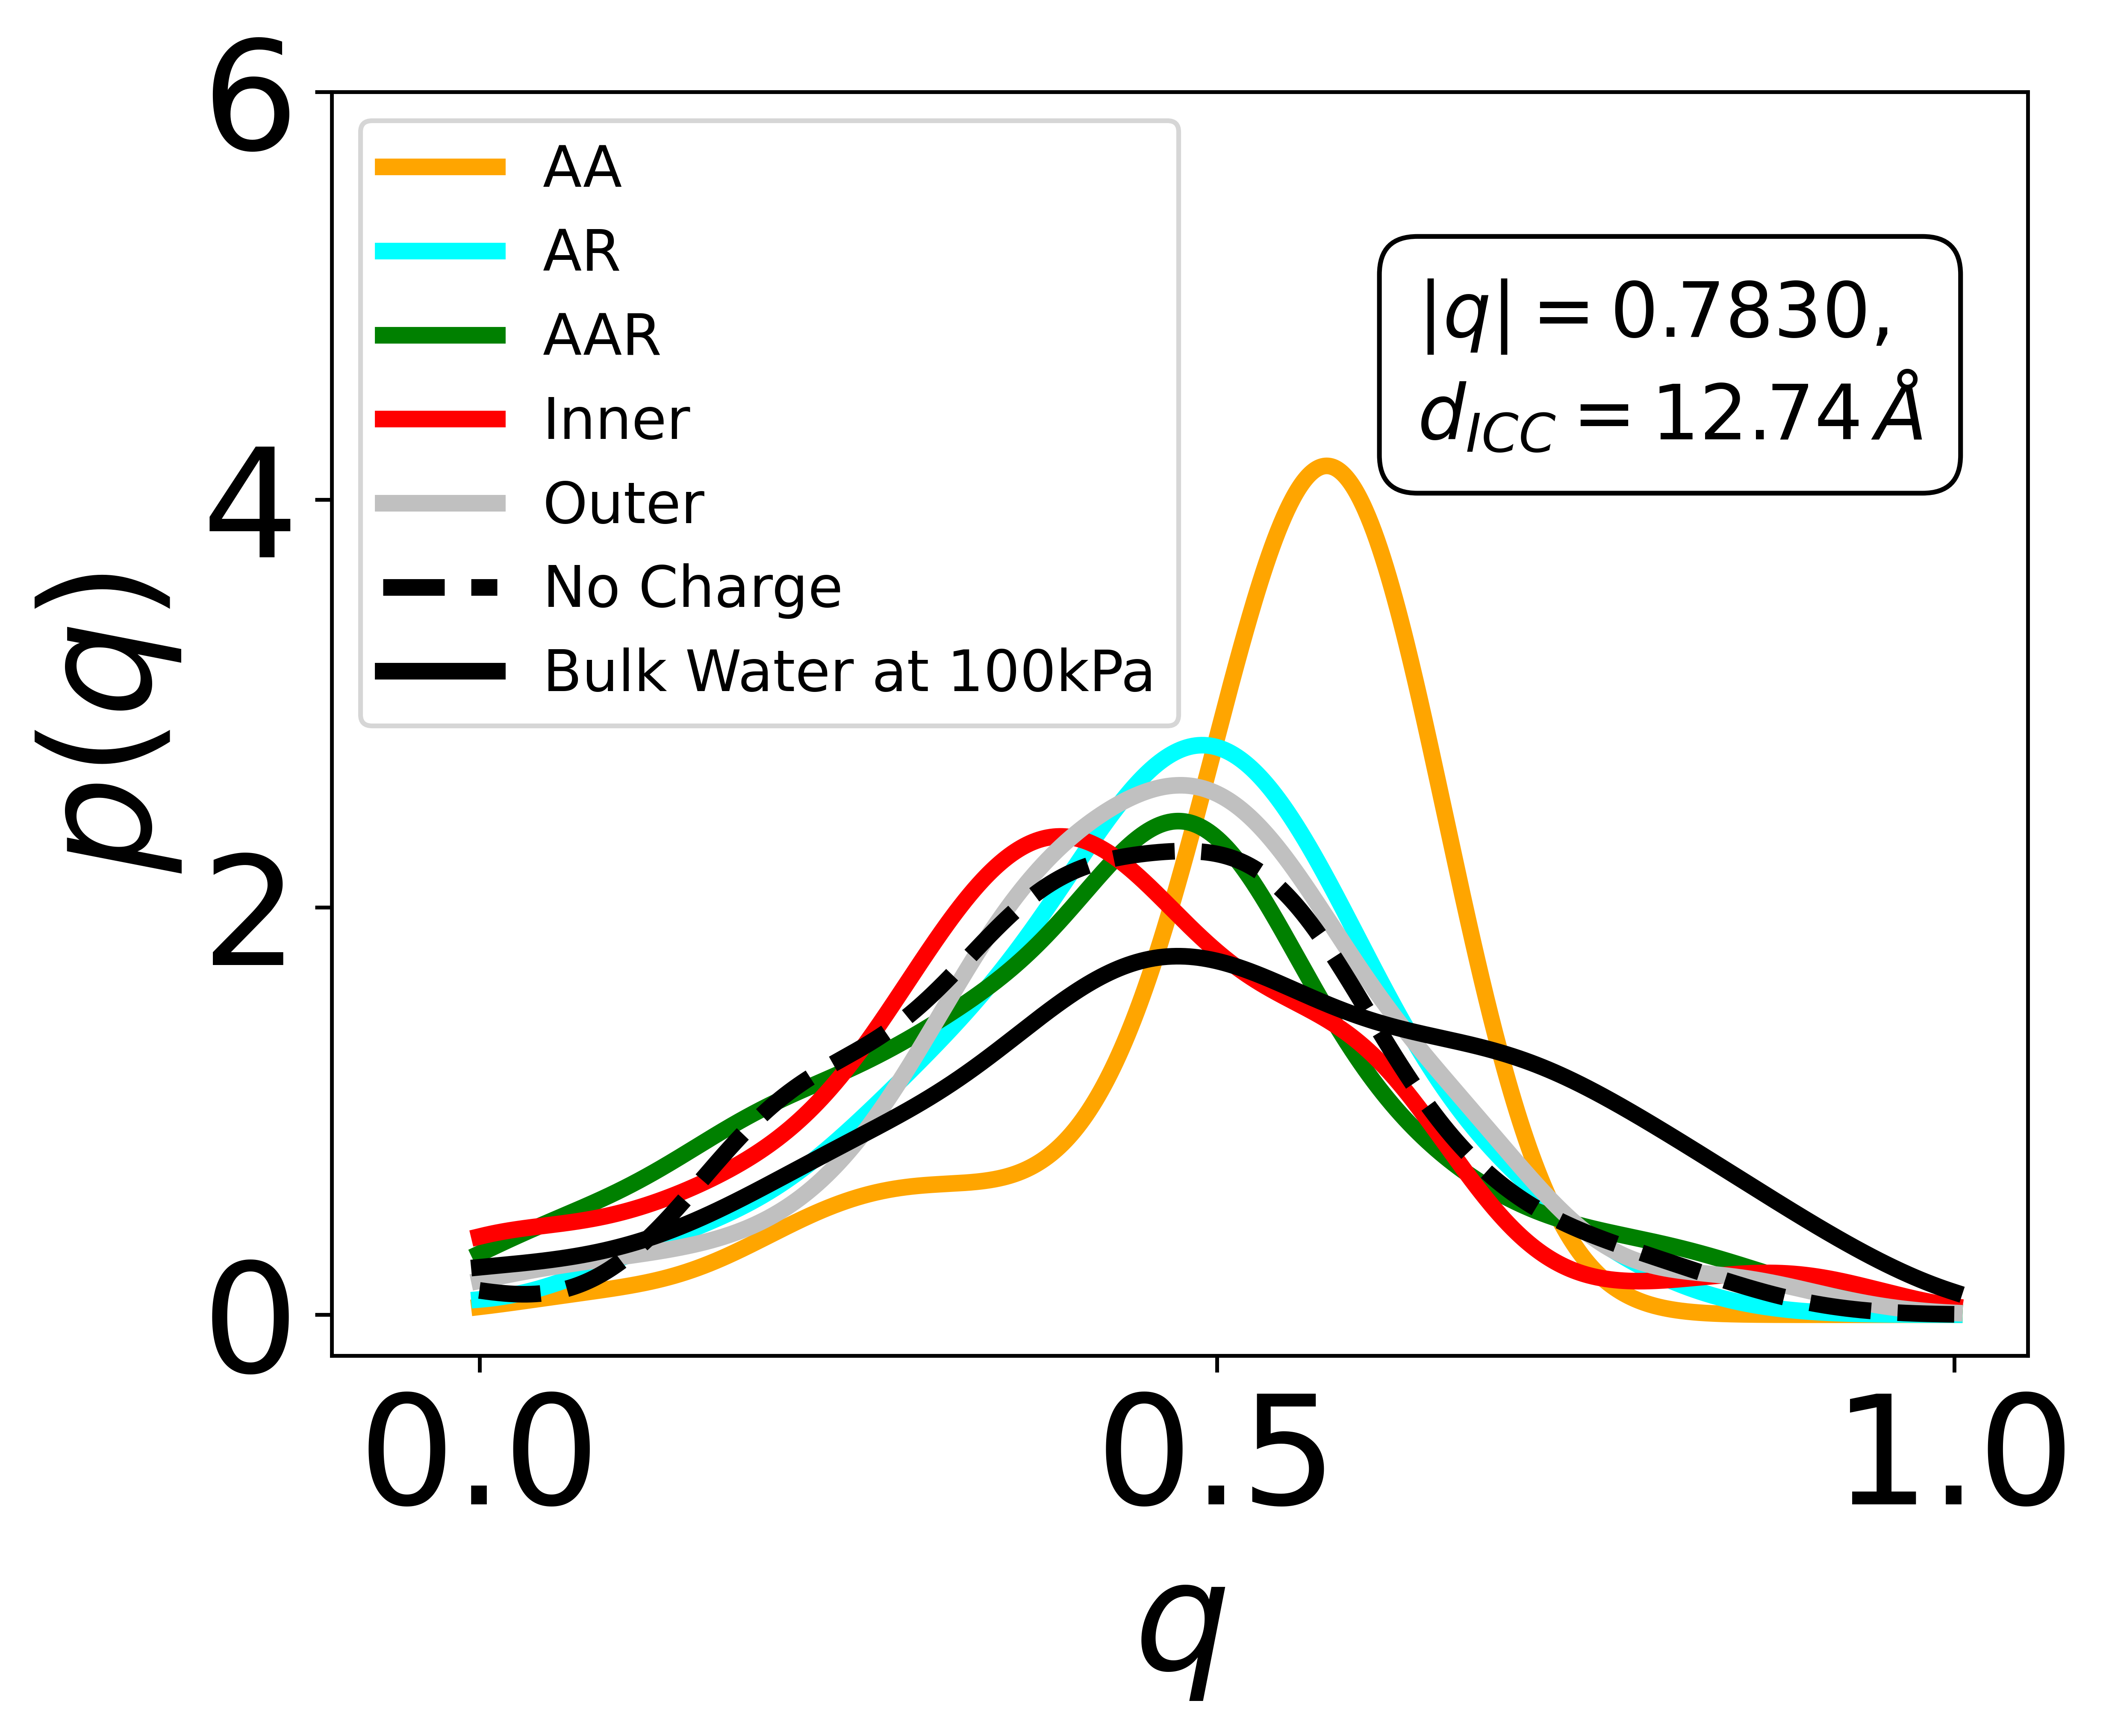

In [2]:
def read_xyz_and_extract_oxygen_positions(filename):
    """Read an XYZ file and extract the positions of oxygen atoms."""
    oxygen_positions = []
    with open(filename, 'r') as f:
        lines = f.readlines()
    for line in lines[2:]:  # Skip the first two lines
        parts = line.strip().split()
        if parts[0] == 'O':
            x, y, z = map(float, parts[1:4])
            oxygen_positions.append([x, y, z])
    return np.array(oxygen_positions)
    
def calculate_q_distribution(oxygen_positions, box_lengths):
    """Calculate the distribution of the orientational tetrahedral order parameter q."""
    q_values = []

    for pos in oxygen_positions:
        # Compute distances to all other oxygen atoms
        distances = np.linalg.norm(minimum_image_distance(oxygen_positions - pos, box_lengths), axis=1)
        neighbor_indices = np.argsort(distances)[1:5]  # Four nearest neighbors
        neighbors = oxygen_positions[neighbor_indices]

        # Calculate normalized vectors to neighbors
        vectors = [minimum_image_distance(neighbor - pos, box_lengths) for neighbor in neighbors]
        vectors = [vec / np.linalg.norm(vec) for vec in vectors]

        # Compute q for this molecule
        q = 0
        for j in range(3):
            for k in range(j + 1, 4):
                cos_psi = np.dot(vectors[j], vectors[k])
                q += (cos_psi + 1/3) ** 2
        q = 1 - (3/8) * q
        q_values.append(q)

    return q_values

# Main code to process each configuration and plot the KDE
configurations = ['AA', 'AR', 'AAR', 'Inner', 'Outer','No_Charge','liquid_100kPa']
labels = ['AA', 'AR', 'AAR', 'Inner', 'Outer','No Charge','Bulk Water at 100kPa']
box_lengths = np.array([30.8, 30.8, 30.8])  # Box dimensions
water_liquid_bl = 31.42196
water_vapor_bl = 485.85066
z_length = 30.80e-8 #cm
r_eff_pore = (7.28/2)*1e-8 #cm
v_pore = np.pi * z_length * (r_eff_pore)**2
v_liq = water_liquid_bl**3
v_vap = water_vapor_bl**3
Vol = [v_pore,v_pore,v_pore,v_pore,v_pore,v_liq,v_vap]

# Determine the shared bandwidth based on a reference dataset
reference_config = configurations[0]  # Choose one configuration as a reference for bandwidth calculation
reference_filename = f"{reference_config}/combined_structure.xyz"
reference_oxygen_positions = read_xyz_and_extract_oxygen_positions(reference_filename)
q_values_reference = calculate_q_distribution(reference_oxygen_positions, box_lengths)

# Perform KDE on the reference dataset to determine the shared bandwidth
kde_reference = gaussian_kde(q_values_reference, bw_method='scott')
#bandwidth_factor = kde_reference.covariance_factor()
#shared_bandwidth = bandwidth_factor * np.std(q_values_reference)
#shared_bandwidth = 1/50**(1/7)
bandwidth_factor = kde_reference.covariance_factor()  # Scott's bandwidth factor
shared_bandwidth = bandwidth_factor * np.std(q_values_reference) 
print(f"Shared Bandwidth Factor (covariance_factor): {bandwidth_factor:.6f}")
print(f"Shared Actual Bandwidth: {shared_bandwidth:.6f}")

colors = ['orange', 'cyan', 'green', 'red', 'silver','k','k']
c = 0
plt.figure(dpi=800)

for config in configurations:
    print(f"Processing configuration: {config}")
    # Assuming each configuration is stored in a separate XYZ file named 'config.xyz'
    filename = f"{config}/combined_structure.xyz"
    oxygen_positions = read_xyz_and_extract_oxygen_positions(filename)
    shape = np.shape(oxygen_positions); total_oxygen = shape[0];
    #no_oxygen = np.length(oxygen_position)
    q_values = calculate_q_distribution(oxygen_positions, box_lengths)
    desired_bandwidth = 1/16

    # Custom bandwidth method
    def fixed_bandwidth_method(data_set,target_bandwidth):
        std_dev = np.std(data_set)
        return target_bandwidth / std_dev  # Compute covariance factor for desired bandwidth

    # Create KDE with fixed bandwidth
    #kde = gaussian_kde(data, bw_method=fixed_bandwidth_method)
    fixed_bandwidth = fixed_bandwidth_method(q_values, desired_bandwidth)
    # Perform Gaussian KDE
    kde = gaussian_kde(q_values,bw_method=fixed_bandwidth)
    # Get the bandwidth factor
    #bandwidth_factor = kde.covariance_factor()  # Bandwidth factor determined by the rule (e.g., Scott's rule)

    # Calculate the actual bandwidth (standard deviation * bandwidth factor)
    #bandwidth = bandwidth_factor * np.std(q_values)
    #kde.set_bandwidth(bw_method = 0.5) 

    # Output the bandwidth settings
    #print(f"Bandwidth Factor (covariance_factor): {bandwidth_factor:.6f}")
    #print(f"Actual Bandwidth: {bandwidth:.6f}")
    bandwidth_factor = kde.covariance_factor()
    bandwidth = bandwidth_factor * np.std(q_values)
    print(f"Covariance Factor: {bandwidth_factor:.6f}")
    print(f"Standard Deviation of Data: {np.std(q_values):.6f}")
    print(f"Bandwidth: {bandwidth:.6f}")
    q_range = np.linspace(0, 1, 1000)
    if labels[c] == 'No Charge':
        plt.plot(q_range, kde(q_range), label=labels[c],color=colors[c],linestyle='--',linewidth=3.5)
    else:
        plt.plot(q_range, kde(q_range), label=labels[c],color=colors[c],linestyle='-',linewidth=3.5)
    # Find the peak of the density and add a vertical dashed line
    peak_index = np.argmax(kde(q_range))
    #peak_x = q_range[peak_index]
    #plt.axvline(x=peak_x, color=colors[c], linestyle='--', linewidth=3.5)
    c += 1

plt.xlabel('$q$',fontsize=32)
plt.ylabel('$p(q)$',fontsize=32)
plt.xlim(-0.1,None)
plt.ylim(-0.2,6)
plt.annotate(r'$|q| = 0.7830$,'+'\n'+'$d_{ICC} = 12.74 \, \AA$', xy=(0.6400, 0.7250), xycoords='axes fraction', 
             fontsize=16, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
#plt.title('Gaussian KDE of the Rotational Order Parameter q for Five Configurations')
plt.legend(loc='upper left',fontsize=12)
plt.show()
